<h1><center>Perceptron Mutli-Couches</center></h1>

Dans ce TP, nous allons implémenter un réseau de neurone simple à deux couches cachée à partir de zéro.
Même si vous utiliserez des bibliothèques de deep learning comme Pytorch ou Tensorflow par par la suite, l'implémentation d'un réseau à partir de zéro au moins une fois est un exercice extrêmement util, essentiel pour concevoir et optimiser ses propres modèles efficacement.



In [58]:
!pip install numpy
!pip install sklearn

# Importations des package utiles
import matplotlib # Pour les tracés
import matplotlib.pyplot as plt 
import numpy as np # Pour réaliser des opération sur des matrices efficacement

# Nous utiliserons la bibliothèque sklearn pour comparer notre réseau de neurone 
# à celui d'une approche plus simple comme une régression logistique
import sklearn 
import sklearn.datasets
import sklearn.linear_model

from math import exp,log

# Pour afficher les plots inline et régler l'affichage
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generation d'un dataset

Commençons par générer un jeu de données avec lequel nous pourrons jouer. La bibliothèque de machine learning scikit-learn dispose de quelques générateurs de données utiles, ce qui nous évite d'avoir à écrire le code nous-mêmes. Nous utiliserons la fonction make_moons, qui crée un dataset à deux classes d'exemples en deux dimensions en forme de deux demi-lunes : chacune des demi-lunes correspond à une classe.

In [59]:
np.random.seed(1)
X, y = sklearn.datasets.make_moons(n_samples=300, noise=0.20)  # On crée un dataset avec 300 éléments

 <font color='red'><b>Question 1.</b></font> Afficher les coordonnées et les labels des deux premiers éléments du dataset.

In [60]:
# Vous pouvez utilisez des f-string comme proposés ci-dessous (https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/)
print(f"Le premier point de coordonnées {X[0]} a comme label {y[0]}")
print(f"Le deuxième point de coordonnées {X[1]} a comme label {y[1]}")

Le premier point de coordonnées [ 0.21073485 -0.0159868 ] a comme label 1
Le deuxième point de coordonnées [-0.82910413  0.65187765] a comme label 0


Nous pouvons afficher ce dataset facilement à l'aide de Matplotlib en utilisant des couleurs pour faire apparaître les labels $y$ : 

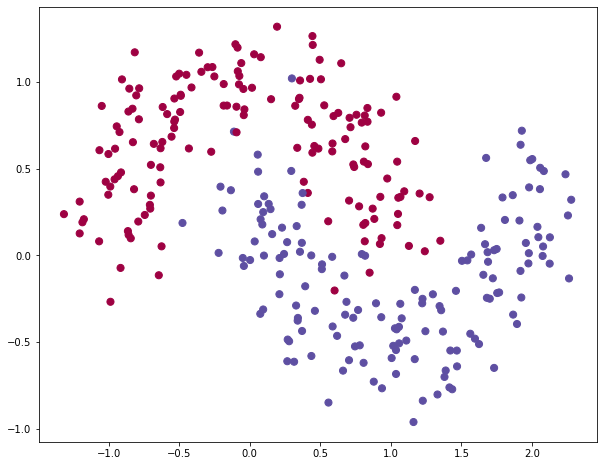

In [61]:
plt.scatter(X[:,0], X[:,1], s=50, c=y+1, cmap=plt.cm.Spectral)
plt.show()

L'ensemble de données que nous avons généré comporte deux classes, représentées par des points rouges et bleus. Vous pouvez considérer les points bleus comme des patients sains et les points rouges comme des patients malades, les axes $x_1$ et $x_2$ étant des mesures médicales.

Notre objectif est d'entraîner un classificateur d'apprentissage automatique qui prédit la classe correcte (sain ou malade) à partir des coordonnées $x_1$ et $x_2$. 

# Trouver la meilleur droite manuellement

Dans cette partie nous allons essayer de trouver la meilleure droite qui sépare notre nuage de points manuellement.

<font color='red'><b>Question 2</b></font>  Crée une fonction qui renvoie 1 si un point de coordonnées $(x_1,x_2$) est en dessous de la droite de coefficient directeur $a$ et d'ordonnée à l'origine $b$.

In [62]:
def pred_linear(a: float, b: float, x1: float, x2: float):
    if a * x1 + b > x2:
        return 1
    else:
        return 0

Il est important de pouvoir évaluer les performances de nos approches grâce à des métriques. Ici, on choisira l'accuracy qui est simplement le nombre d'éléments bien classifié divisé par le nombre total d'éléments. 

Pour en savoir plus sur les métriques de classification comme la précision, le rappel et leur lien avec l'accuracy, vous pouvez consulter l'excellente Wikipedia suivante (si vous comptez faire du Machine Learning par la suite, la notion de précision/rappel est un classique) https://en.wikipedia.org/wiki/Precision_and_recall

<font color='red'><b>Question 3.</b></font> Compléter la fonction accuracy suivante. (1 ligne Python avec une compréhension de liste)

In [63]:
def accuracy(y_true, y_pred):
    """
    Args:
        y_true (list[int]): liste d'entier dans {0,1} contenant les labels
        y_pred (list[int]): liste d'entier dans {0,1} contenant les prédictions du modèle 

    Returns:
        float: Accuracy du modèle
    
    Usage examples:
    >>> accuracy([0,0,1], [0,1,1])
    0.666...
    """
    nb_correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            nb_correct += 1
    return nb_correct / len(y_true)

In [64]:
#### fonction d'affichage
def plot_decision_boundary(pred_func):
    """
    Affiche les frontières de décision d'une fonction de prédiction binaire.
    """
    # Définir les dimensions de la grille et donner un peu de marge pour l'affichage
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    # Générer la grille de points avec un distance de h entre eux
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Tracer la frontière de décision
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Afficher le contour et les points d'entrainements
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

<font color='red'><b>Question 4.</b></font>  Jouez à la main avec des paramètres $a$ et $b$ pour obtenir plusieurs frontrières de décisions linéaires et essayez d'obtenir au moins 80% d'accuracy.



le score obtenu est de:  0.85


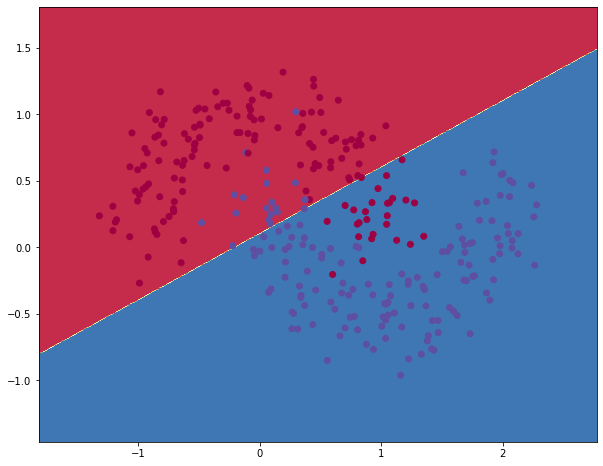

In [65]:
a = 0.5
b = 0.1
def prediction(A, a, b, func):
    return np.array([func(a=a, b=b, x1=x[0], x2=x[1]) for x in A])
plot_decision_boundary(lambda x: prediction(x, a, b, pred_linear))
print('le score obtenu est de: ', accuracy(y, prediction(X, a, b, pred_linear)))

# Régression Logistique

Scikit-learn possède des modèles tels que la régression logistique qui permet de trouver les paramètres a et b optimaux:

In [66]:
classifier = sklearn.linear_model.LogisticRegressionCV()

 <font color='red'><b>Question 5.</b></font> Entraîner ce modèle de régression logistique sur le dataset (X,y). Vous pouvez vous aider de la documentation de Scikit-learn pour voir comment entrainer un modèle sur des données : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [67]:
classifier.fit(X, y)

LogisticRegressionCV()

Une fois le modèle entrainé, on peut l'utiliser pour prédire et tracer la frontière de décision :

le score obtenu est de:  0.8566666666666667


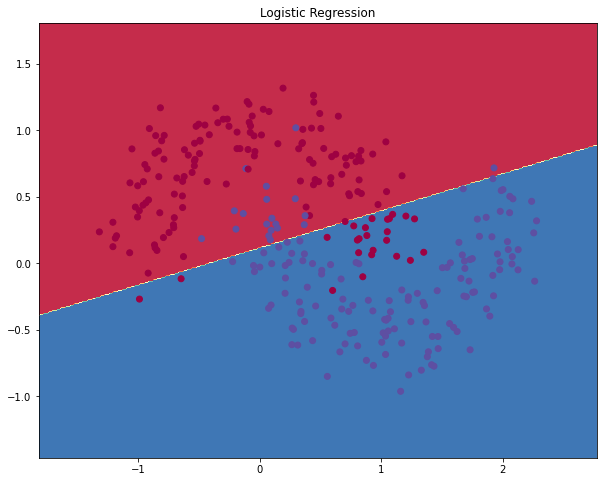

In [68]:
plot_decision_boundary(lambda x: classifier.predict(x))
plt.title("Logistic Regression")
print('le score obtenu est de: ', accuracy(y, classifier.predict(X)))

 <font color='red'><b>Question 6.</b></font> Qu'observez vous ? Est ce que un tel résultat était prévisible ? Que faire pour améliorer nos prédictions ?

In [69]:
"Le résutat était prévisible puisqu'il est impossible de tracer une droite séparant parfaitement nos deux ensembles de points. Une solution possible serait de dessiner une courbe."

"Le résutat était prévisible puisqu'il est impossible de tracer une droite séparant parfaitement nos deux ensembles de points. Une solution possible serait de dessiner une courbe."

<font color='red'><b>Question Bonus.</b></font> Retrouver les coefficients $a, b$ obtenus par la régression logistique de Scikit-learn.

In [70]:
#TODO

# Réseau de neurones

Vous allez maintenant créer un réseau de neurones pour résoudre le probleme précédent.

In [71]:
# On va réutiliser le même datasets que précédemment, attention X et y seront des variables globales
# pour la suite (à éviter en général, mais simplifie les notations pour ce petit TP)
np.random.seed(1)
X, y = sklearn.datasets.make_moons(300, noise=0.20)

 <font color='red'><b> Question 7</b></font> Compléter les variables et les fonctions suivantes pour coder un réseau de neurones à **deux couches cachées**. Chaque couche cachée aura pour l'instant **10 neurones** et on utilisera un learning rate de 1e-2.

In [72]:
# nombre d'exemples dans la base d'entrainement
N =  len(X)

# dimension de l'entrée du réseau
d_input = 2 

# dimension de la sortie du réseau 
d_output = 2

# dimension des couches cachées i.e. nombre de neurones des couches cachées
d_hidden = 10



# Paramètres de la descente de gradient :
# learning rate pour la descente de gradient
epsilon = 0.01


 <font color='red'><b> Question 8</b></font> Compléter la fonction suivante afin de générer les pamètres de notre réseau de neurones. Pour cela vous utiliserez la bibliothèque random pour généréer des paramètres dans l'intervalle [-0.5, 0.5] grace à la fonction random.random().

In [73]:
import random

In [74]:
def init_model(d_input: int, d_hidden: int, d_output: int):
    """
    Args:
        d_input (int): dimension de l'entrée du réseau
        d_hidden (int): dimension de la sortie du réseau 
        d_output (int): dimension des couches cachée

    Returns:
        dict: Dictionnaire contenant 4 clefs, les poids/biais (W1,b1) et (W2,b2) du réseau de neurone. 
        Chacun de ces poids et de ces biais sont des listes ou liste de listes de float.
    """
    # Initialisation des paramètes aléatoires
    random.seed(0)
    # Première couche de taille d_input x d_hidden
    W1 = [[random.random()-0.5 for _ in range(d_hidden)] for x in range(d_input)]
    # Biais de la première couche vecteur de taille d_hidden
    b1 = [0 for _ in range(d_hidden)]
    # Seconde couche de taille d_hidden x d_output
    W2 = [[random.random()-0.5 for _ in range(d_output)] for x in range(d_hidden)]
    # Biais de la seconde couche
    b2 = [0 for _ in range(d_output)]
    # Le modèle retourné à la fin, c'est un dictionnaire des poids et de biais
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

<font color='red'><b> Question 9</b></font> Implémenter les fonctions mathématiques suivantes qui pourront être utiles dans la suite. Tous les vecteurs $v_1,v_2$ sont des listes pythons et les matrices $X$ et $W$ sont des listes de listes.

In [75]:
# Produit sclaire entre deux vecteurs
def dot_product(v1, v2):
    product = 0
    for i in range(len(v1)):
        product += v1[i] * v2[i]
    return product
        
# Additionner deux vecteurs
def add_bias(v1, v2):
    result = [0 for _ in range(len(v1))]
    for i in range(len(v1)):
        result[i] = v1[i] + v2[i]
    return result

# Obtenir la columns numero "index" de W
def get_columns(W, index):
    col = []
    for l in range(len(W)):
        col.append(W[l][index])
    return col

# Transposer une matrice
def transpose(W):
    T = [[0 for _ in range(len(W))] for i in range(len(W[0]))]
    for i in range(len(W)):
        for j in range(len(W[0])):
            T[j][i] = W[i][j]
    return T

# Multiplication entre deux matrices ()
def matrix_multiplication(X, W):
    nb_cols = len(W[0])
    nb_lignes = len(X)

    M = [[0 for _ in range(nb_cols)] for i in range(nb_lignes)]
    for l in range(nb_lignes):
        for c in range(nb_cols):
            M[l][c] = dot_product(X[l], get_columns(W, c))
    return M

 <font color='red'><b> Question 10</b></font> Compléter la fonction forward_layer en effectuant l'opération suivante:
 $$ X \times W + b $$
 Dans laquelle X représent l'entrée, W les poids et et b les biais.
 Compléter la fonction sigmoid et feed_forward.

In [76]:
def forward_layer(X, W, b):
    m = matrix_multiplication(X, W)
    
    for l in range(len(m)):
        m[l] = add_bias(m[l], b)
    
    return m


In [77]:
def sigmoid(Z):
    return [[1 / (1 + exp(-Z[l][c])) for c in range(len(Z[0]))] for l in range(len(Z))]

                    
def softmax(Z):
    result = [[0 for _ in range(len(Z[0]))] for __ in range(len(Z))]
    
    for l in range(len(Z)):
        sum_exps = 0
        for c in range(len(Z[l])):
            sum_exps += exp(Z[l][c])
        
        for c in range(len(Z[l])):
            result[l][c] = exp(Z[l][c]) / sum_exps
    return result

In [78]:
def forward_function(X,W1,b1,W2,b2):     
    z1 = forward_layer(X, W1, b1) #Sortie de la première couche
    a1 = sigmoid(z1) #Activation sigmoid de la première couche
    z2 = forward_layer(a1, W2, b2)  #Sortie de la deuxième couche
    exp_scores = sigmoid(z2)
    probs = softmax(z2) # Appliquer la fonction d'activation softmax sur z2
    return probs

In [79]:
# Tester votre résultat sur un dataset aléatoire :
np.random.seed(1)
model_test = init_model(4,3,2)
X_debug = [[random.random() for i in range(2)]] # Test avec un exemple en dimension 2}
forward_function(X_debug, model_test['W1'], model_test['b1'], model_test['W2'], model_test['b2'])

[[0.48149557238903795, 0.5185044276109622]]

Vous devriez trouver  : [[0.480..., 0.519...]]

 <font color='red'><b> Question 11</b></font> On rappel les équations du feed forward (tout est sous forme matricielles avec la convention de considérer que chaque exemple est un vecteur ligne), donc $X\in\mathbb{R}^{N\times d_{input}}$,$W_1\in\mathbb{R}^{d_{input}\times d_{hidden}}$, etc). Compléter  les équations de la back propagation (cela vous demandera un peu de calcul mais pas besoin de mettre le détail ici) et compléter la fonction sigmoid,forward function et train_model. La descente de gradient sur W1 vous est fournie. 

$$
\begin{aligned}
z_1 & = XW_1 + b_1  \\ 
a_1 & = sigmoid(z_1)=\frac{1}{1+\exp(-z_1)} \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)\\
L(y,\hat{y}) & = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$
Back propagation :
$$
\begin{aligned}
& \delta_2 =  a_2 - y\\
& \delta_1 = (sigmoid(z_1)*(1 - sigmoid(z_1)) \odot(delta_2 * (W_2)^t)\\
& \frac{\partial{L}}{\partial{W_2}} = (a_1)^t * delta_2\\
& \frac{\partial{L}}{\partial{b_2}} = delta_2\\
& \frac{\partial{L}}{\partial{W_1}} = (X)^t * delta_1\\
& \frac{\partial{L}}{\partial{b_1}} = delta_1 \\
\end{aligned}
$$

In [89]:
def term_matrix_multiplication(X, W):
    result = [[0 for _ in range(len(X[0]))] for __ in range(len(X))]
    for l in range(len(X)):
        for c in range(len(X[0])):
            result[l][c] = X[l][c] * W[l][c]
    return result


def train_model(model, nn_hdim, num_epochs=1, print_loss=False):
    W1 = model['W1']
    b1 = model['b1']
    W2 = model['W2']
    b2 = model['b2']
    losses = [] # stocker les losses à chaque epoch
    for i in range(0, num_epochs):
        # Forward propagation
        z1 = forward_layer(X, W1, b1)   
        a1 = sigmoid(z1)
        z2 = forward_layer(a1, W2, b2)
        probs = softmax(z2)
        # Calcul de la loss (c)    
        data_loss = 0
        for j in range(len(probs)):
            data_loss += -log(probs[j][y[j]])
            
        data_loss = 1./N * data_loss # Loss totale
        losses.append(data_loss) # stocker la loss pour cette epoch

        # Backpropagation
        delta2 = probs
        for y_pred, y_attendu in zip(delta2, y):
            y_pred[y_attendu] -= 1
        
        dW2 = matrix_multiplication(transpose(a1), delta2)
        db2 = [sum(dw2_row) for dw2_row in transpose(delta2)] # On transpose pour simplifier le calcul de db2
        delta1 = matrix_multiplication(delta2, transpose(W2))        
        
        #calcul dérivée de sigmoid
        dz1 = [[ a*(1 - a) for a in row] for row in a1]
        delta1 = term_matrix_multiplication(dz1, delta1)        
        dW1 = matrix_multiplication(transpose(X),delta1)
        db1=[sum(row) for row in transpose(delta1)] # On transpose pour simplifier le calcul de db1
        
        # Descente de gradient
        W1 =[[w - epsilon * d for d, w in zip(dW1_row, W1_row)]for dW1_row, W1_row in zip(dW1, W1)]
        b1 = [b - epsilon * d for d, b in zip(db1, b1)]
        W2 = [[w - epsilon * d for d, w in zip(dW1_row, W1_row)]for dW1_row, W1_row in zip(dW2, W2)]
        b2 = [b - epsilon * d for d, b in zip(db2, b2)]
        
        # Mise à jour des poids et des biais
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Affichage de la loss
        if print_loss and i % 50 == 0:
          print("Loss a l'époque %i: %f" %(i, data_loss))
      
    return model, losses

Nous aurons besoin d'une fonction de prédiction qui se sert de notre modèle entrainé pour renvoyer des prédictions. Contrairement aux sorties du modèle qui sont des float dans [0,1] pour chaque classe, la prédiction du modèle vaut 1 sur la classe dont le score est maximale et 0 ailleurs. On utilise la fonction argmax de numpy pour faire cela automatiquement.

<font color='red'><b> Question 11</b></font> Compléter la fonction predict() :

In [90]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation, exactement comme avant
    z1 = forward_layer(X, W1, b1)
    a1 = sigmoid(z1)
    z2 = forward_layer(a1, W2, b2)
    exp_scores = sigmoid(z2)
    probs = softmax(z2)
    return np.argmax(probs, axis=1)

<font color='red'><b> Question 12</b></font> Entrainer le modele pour différents nombre d'epochs et commenter vos résultats.



In [91]:
"Lorsque le loss diminue très rapidement lors de 50 premières époques mais diminue très lentement une fois les 100 époques atteintes. Il faut toutefois beaucoup d''époques (environ 1200) pour arriver à une loss inférieure à 10e-1."

"Lorsque le loss diminue très rapidement lors de 50 premières époques mais diminue très lentement une fois les 100 époques atteintes. Il faut toutefois beaucoup d''époques (environ 1200) pour arriver à une loss inférieure à 10e-1."

In [92]:
model = init_model(d_input,d_hidden,d_output)
model, losses = train_model(model,d_hidden, num_epochs=500, print_loss=True)
print("L'accuracy finale obtenue est de :", accuracy(y, predict(model, X)))

Loss a l'époque 0: 0.675440
Loss a l'époque 50: 0.296435
Loss a l'époque 100: 0.295836
Loss a l'époque 150: 0.295507
Loss a l'époque 200: 0.295234
Loss a l'époque 250: 0.294992
Loss a l'époque 300: 0.294768
Loss a l'époque 350: 0.294554
Loss a l'époque 400: 0.294345
Loss a l'époque 450: 0.294136
L'accuracy finale obtenue est de : 0.8566666666666667


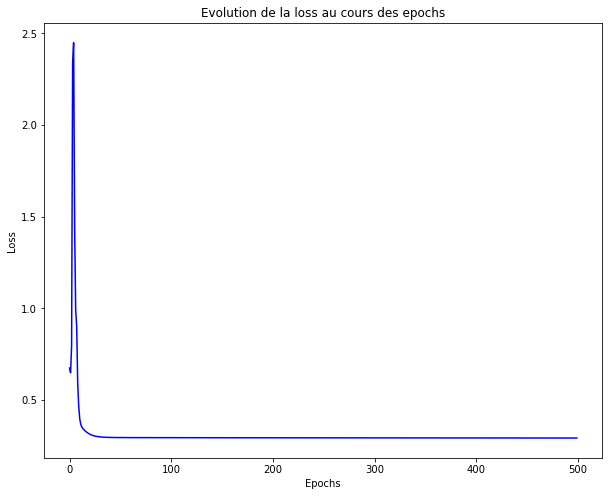

In [94]:
# #Plot the decision boundary
import matplotlib.pyplot as plt
num_epochs=500
epochs = range(num_epochs)
plt.plot(epochs, losses, 'b')
plt.title('Evolution de la loss au cours des epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


<font color='red'><b> Question 13 </b></font> 
Effectuer une validation croisée pour trouver des bons hyper-paramètres sur votre modèle. Pourquoi laisser une partie du jeu de donnée de côté à chaque entrainement ?



In [95]:
print("Il est important de laisser une partie du jeu de données de côté à chaque entrainement pour éviter que notre modèle ne sur-apprenne sur notre ensemble d'''entraînement. Si nous n'utilisions pas un ensemble de test séparé, il serait très facile d''ajuster nos hyperparamètres pour obtenir une précision élevée sur notre ensemble d''entraînement, mais cela ne garantirait pasune bonne généralisation à de nouveaux exemples. En utilisant un ensemble de test séparé, nous nous assurons que notre modèle généralise bien à de nouveaux exemples.")

Il est important de laisser une partie du jeu de données de côté à chaque entrainement pour éviter que notre modèle ne sur-apprenne sur notre ensemble d'''entraînement. Si nous n'utilisions pas un ensemble de test séparé, il serait très facile d''ajuster nos hyperparamètres pour obtenir une précision élevée sur notre ensemble d''entraînement, mais cela ne garantirait pasune bonne généralisation à de nouveaux exemples. En utilisant un ensemble de test séparé, nous nous assurons que notre modèle généralise bien à de nouveaux exemples.


# Application sur un vrai jeu de données

Nous allons maintenant appliquer notre modèle sur un vrai jeu de donnée bien connu dans le monde du Machine Learning : le MNIST (https://en.wikipedia.org/wiki/MNIST_database) qui est dans Sklearn.

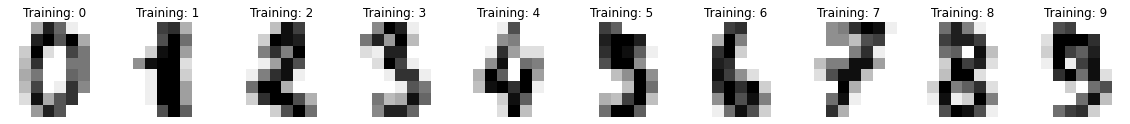

In [96]:
digits = sklearn.datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [97]:
X =  digits.images.reshape((n_samples, -1)) # On reshape les images en vecteur 
y = digits.target


<font color='red'><b> Question 14 </b></font> Compléter les dimensions d'entrée et de sortie de votre réseau pour qu'il soit adapté au Dataset MNIST et relancer l'entrainement (attention, l'entrainement prendra maintenant quelques minutes sans optimisation du code supplémentaire). Jouez sur les hyper-paramètres pour obtenir le meilleur score possible sur MNIST.

In [98]:
N = len(X) 
d_input = 64
d_output = 10
d_hidden = 20 

# Parametre de la descente de gradient
epsilon = 0.001 # le learning rate doit être plus petit qu'avant sinon l'entrainement diverge

In [ ]:
model = init_model(d_input,d_hidden,d_output)
model = train_model(model,d_hidden, num_epochs=700, print_loss=True)
print("L'accuracy finale obtenue est de :", accuracy(y, predict(model, X)))


Loss a l'époque 0: 2.536820


<font color='red'><b> Questions 15 (Bonus) </b></font> Il y a de nombreuses manières de rendre votre réseau de neurone plus performant, vous pouvez vous renseigner sur les points d'améliorations suivants de votre choix, expliquer leur utilité et implémenter ceux que vous voulez en analysant les nouveaux résultats obtenus (sur le jeu de donnée de votre choix). N'hésitez pas à être curieux et à chercher de bonnes ressources pour vous aider !
* Ajout de Weight Decay (https://fr.wikipedia.org/wiki/Weight_decay)
* Utilisation de la bibliothèque Numpy pour gérer les opérations matricielles, plutôt que d'utiliser des listes de listes Python (cela simplifiera votre code et devrait diminuer les temps d'entrainement de plusieurs ordres de magnitude selon la taille de votre réseau, ce qui vous permettra d'entrainer des plus grand réseaux et de mieux optimiser les hyperparamètres sur le dataset MNIST)
* Ajout de couches plus profondes (faire en sorte que le nombre de couches soit un paramètre du modèle)
* Descente de Gradient Stochastique ou par Batch (https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique)